# Comparison of the Coronavirus outbreak among countries

Sunday, March 10, 2020

This notebook is intended to check what is the oubreak evolution in each country, and to some extent to forecast what may be the next steps: some countries were exposed after some others, and **we have the opportunity to see the path they followed and to compare it to the countries that are now exposed.**

The notebook is using **ECDC data** (https://www.ecdc.europa.eu). Unfortunately the data is **lagging roughly 2 days**, so you may have to add your own data points if you want to have realtime graphics.

China, and now Italy are providing statistics that can be used for this purpose.
This notebook shows that France is roughly following the same path 9 days later, and the USA too.
**We are using the number of deaths to study the outbreak, as those numbers may prove more precise than the case numbers, which are subject to different policies among countries.**

What we can note is that the **initial natural trend is doubling of the deaths every 2 days**. This is very fast, as some pandemics show that this doubling is usually observed every 6 days.
**China deaths curve show a large slowing down of the outbreak after this initial phase, that may related to a very strong policy to contain it.**
**Italy shows no slowdown since the beginning**, we are still in this early phase. The next days will show if the curve follows China curve, or if the exponential growth will go on for more days, especially that a full lockdown has been declared in the country.
It's probably too early for France and USA to conclude, but the trend is very similar right now.

**Following graphs are using logarithmic scale, because that's the right thing to do when processing data about an exponential process. That should not hide the fact that the growth is much more severe that what those graphs seems to convey.**




In [114]:
# import urllib
import datetime
import matplotlib
import matplotlib.pyplot as plt
import pathlib
import math
import json

%matplotlib notebook

country_data = None

def prepare_data_from_ecdc():
    global country_data
    if country_data == None:
        country_data = {}

        from pandas import DataFrame, read_csv
        import matplotlib.pyplot as plt
        import pandas as pd 

        date = "2020-03-09"
        url = "https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-%s.xls" % date        
        data = urllib.request.urlopen(url).read()    
        filename = "data/ecdc/" + date + ".xls"
        f = open(filename, "wb")
        f.write(data)
        f.close()

        df = pd.read_excel(filename)
        for i in range(df.shape[0]):
            country = str(df["CountryExp"][i])
            cases = int(df["NewConfCases"][i])
            deaths = int(df["NewDeaths"][i])
            date = str(df["DateRep"][i])
            if country not in country_data:
                country_data[country] = []

            entry = {"date":date, "cases":cases, "deaths":deaths}
            country_data[country].append(entry)
        
        for country, data in country_data.items():
            data.sort(key = lambda x : x["date"])

            cases = 0
            deaths = 0
            for d in data:
                cases += d["cases"]
                deaths += d["deaths"]
                d["cases"] = cases
                d["deaths"] = deaths
            
def get_data_from_ecdc(country):
    global country_data
    prepare_data_from_ecdc()
    return country_data[country]

def get_data_per_country(country, reset = False):
    return get_data_from_ecdc(country)
        
    

prepare_data_from_ecdc()


In [120]:
wikipedia = False
if wikipedia:
    countries = ["China", "France", "South_Korea", "Italy", "United States", "Germany", "Iran", "Spain"]
    # Update Data from wikipedia:
    update = False
    if update:
        for c in countries:
            get_data_from_wikipedia(c, reset = True)


china_offset= 37
offset_by_country = dict(China=0,
                         France=-9.5 - china_offset, 
                         Italy=0 - china_offset, 
                         Germany=-9 - china_offset, 
                         United_States_of_America=-8 - china_offset,
                         South_Korea=2 - china_offset,
                         Iran=2 - china_offset,
                         Japan=30 - china_offset,
                         Spain=-11 - china_offset)

In [121]:
def plot_date_values(country, values, offset, multiplier, log_axis, label, key):
    start_time = datetime.datetime(2020, 1, 1)
    dates = [(datetime.datetime.fromisoformat(v["date"]) - start_time).days  + offset for v in values]
    y = [v[key] * multiplier for v in values]
    if log_axis:
        y = [a for a in y]
    if log_axis:
        plt.yscale("log")    
    
    plt.plot(dates, y, label = label + " %d days" % offset)
    
def finalize_plot_comparison(key, start, end, reference_shift):
    time_base = 2.2
    plt.plot([max(1, 2**((x - reference_shift) / time_base)) for x in range(0, 40)],
             label="Doubling every %s days" % time_base,
            linestyle='dotted')

    _ = plt.legend()
    plt.title("%s by country over time.\n Logarithmic scale.\n X axis is custom shifted for each country to take into account different start time." % key.capitalize(),
            fontdict = {'fontweight' : "bold", 'verticalalignment': 'baseline'})
    plt.xlabel("Days since 01-01-2020 (for China, use offset for other countries)")
    plt.ylabel(key)
    plt.xlim(start, end)

def get_offset_by_country(country):
    return offset_by_country[country.replace(" ", "_")]
    
def plot_comparison(countries, key, start = 8, end = 78, reference_shift = 12.5):    
    """Key parameters is 'cases' or 'deaths'"""
    log_axis = True
    
    # This dictionary can be used to correct for different countries testing policies
    multiplier_by_country = dict()
    default_multiplier = 1
    
    fig=plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')

    for i, country in enumerate(countries):

        data_for_country = get_data_per_country(country)
        plot_date_values(country,
                         data_for_country,
                         get_offset_by_country(country),
                         multiplier_by_country.get(country, default_multiplier),
                         log_axis, country, key)
    finalize_plot_comparison(key, start, end, reference_shift)
    
        

<IPython.core.display.Javascript object>


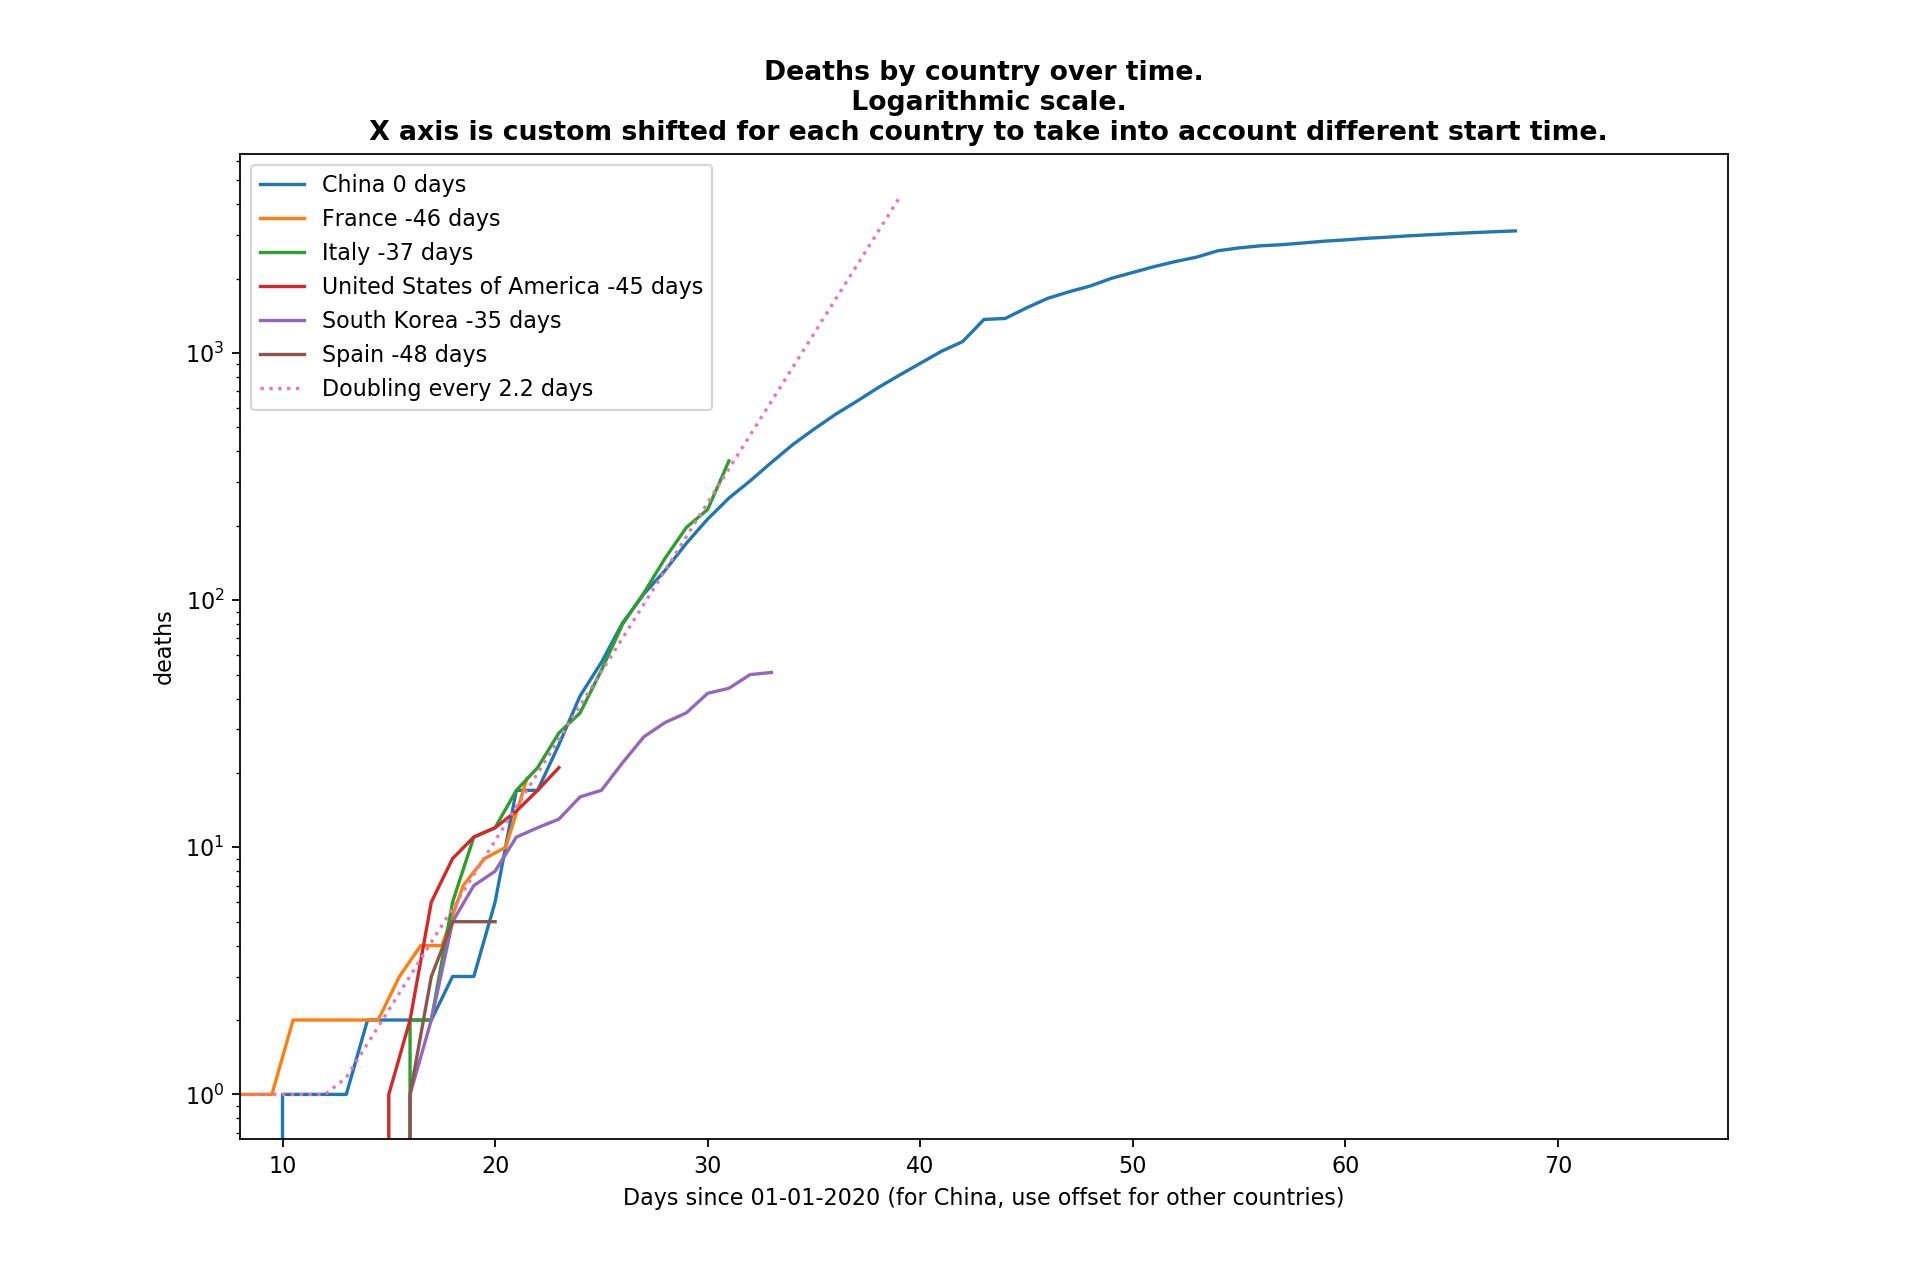

In [122]:
countries = ["China", "France", "Italy", "United States of America", "South Korea", "Spain"] #, "Germany", "Iran", "Spain", ]
plot_comparison(countries, "deaths")


# Notes on number of deaths

## Time offsets
China obviously came first.
Italy and South Korea almost at the same time, 36 days later.
Then France and USA are roughly 9 days behind Italy and South Korea.
It's important to note this, as you can tell somehow what will happen to you by looking at the previous countries.

## South Korea
From the graphics, it looks like *South Korea* is doing quite well to limit the number of deaths.
It looks like too that there was at least two steps in the growth, one stabilizing at 12 deaths, and a second growth stabilizing at 44.

## Italy
The curve for *Italy* is much more worrying : no inflection is visible right now, the growth is still exponential.

## United States
It's a bit early to be sure of anything, but the curve clearly follow an exponential growth right now

## France
A first cluster appeared early, explaining the early start, and a second wave has started. Right now it's difficult to judge of the trend.



<IPython.core.display.Javascript object>


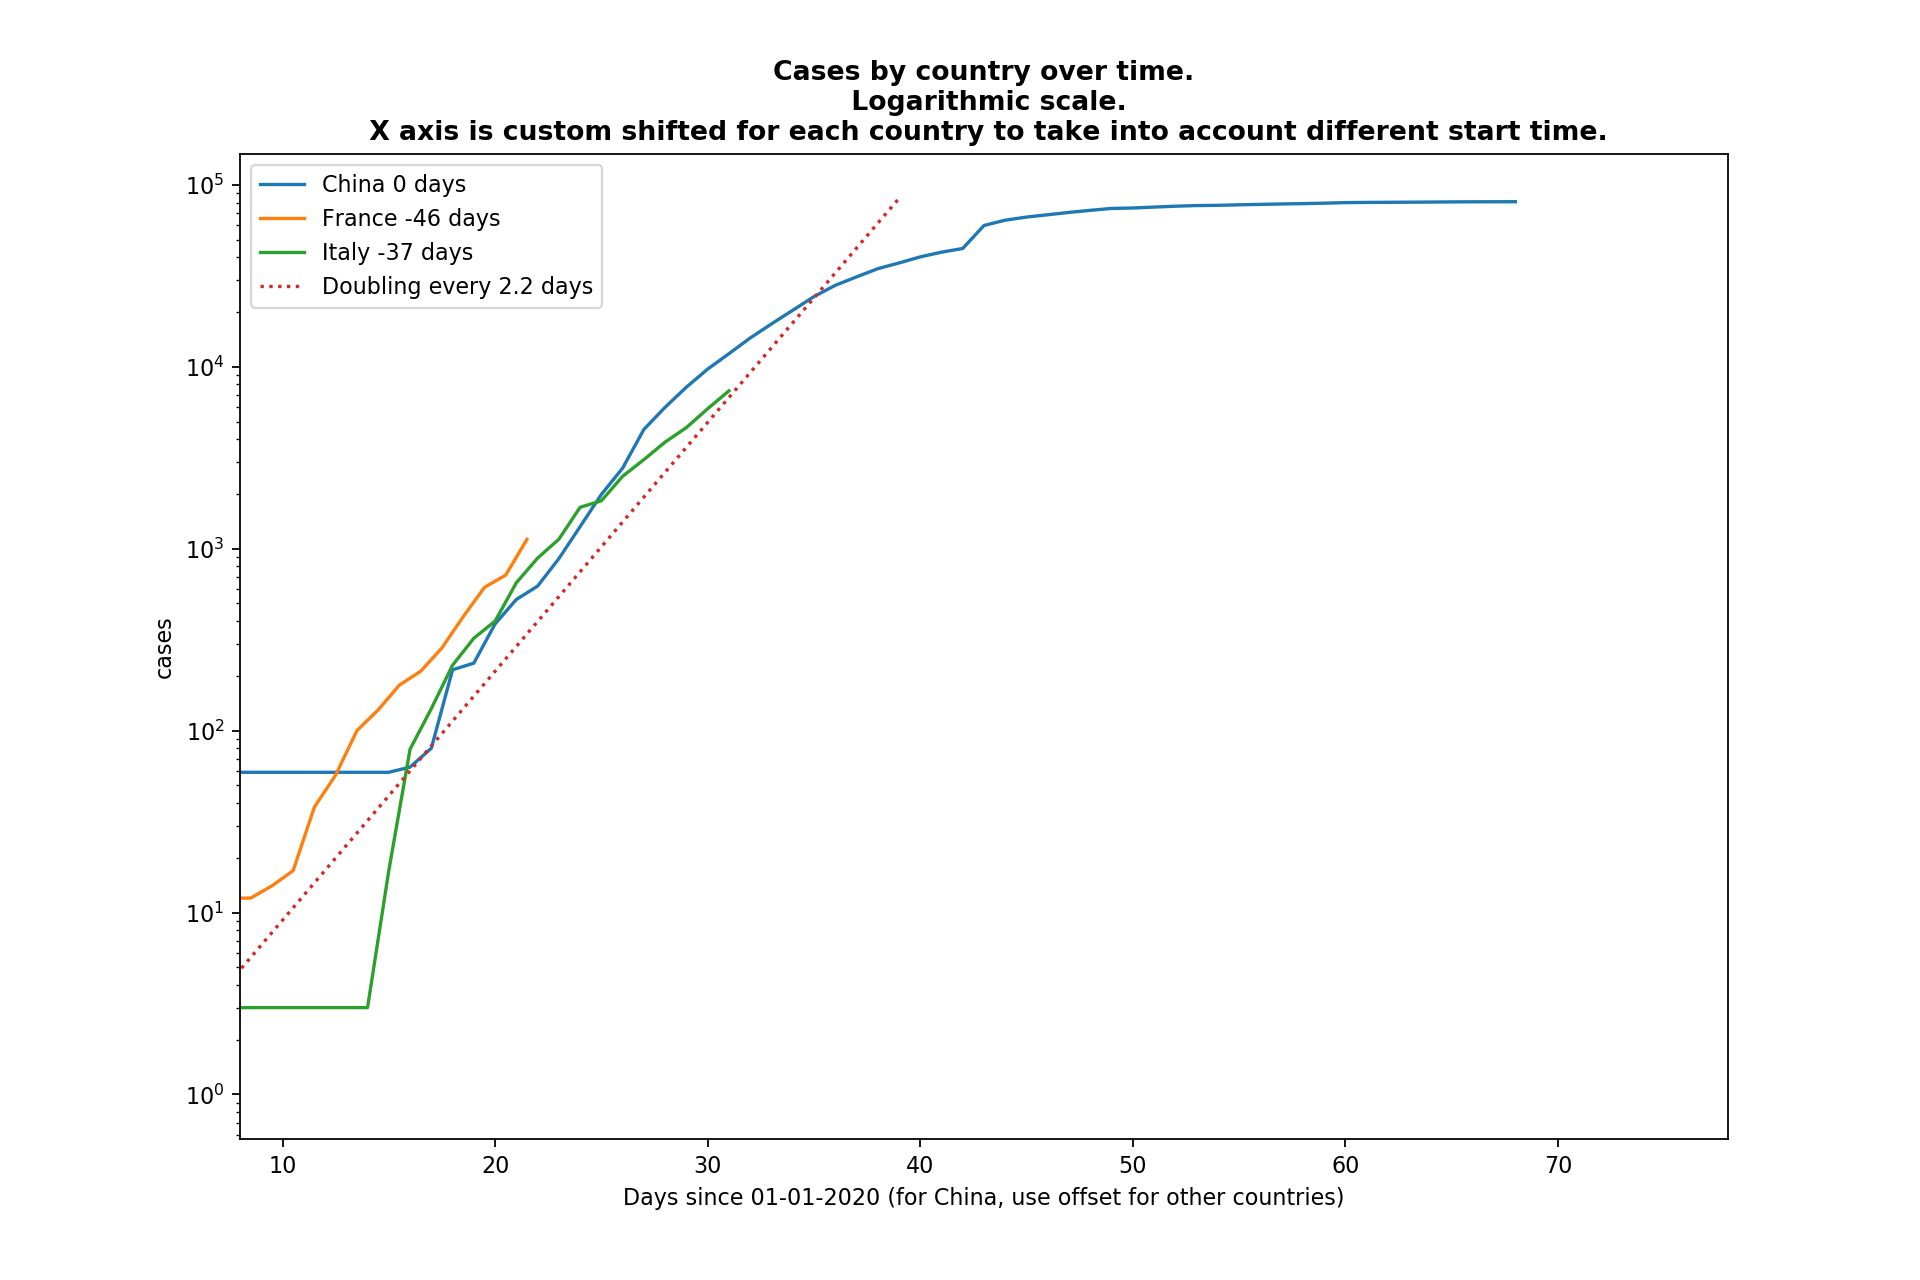

In [113]:

plot_comparison(countries, "cases", reference_shift = 3)

# Notes on numbers of cases

We are using there the same time shifts we used for the deaths.
It's apparent that the different curves are slightly separated (but on a logarithmic scale it can means a bit more).
My interpretation is that the testing policies of the different countries can be different, so you may have to compensate for this (South Korea and Italy did a lot of tests).




